<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm_notebook

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

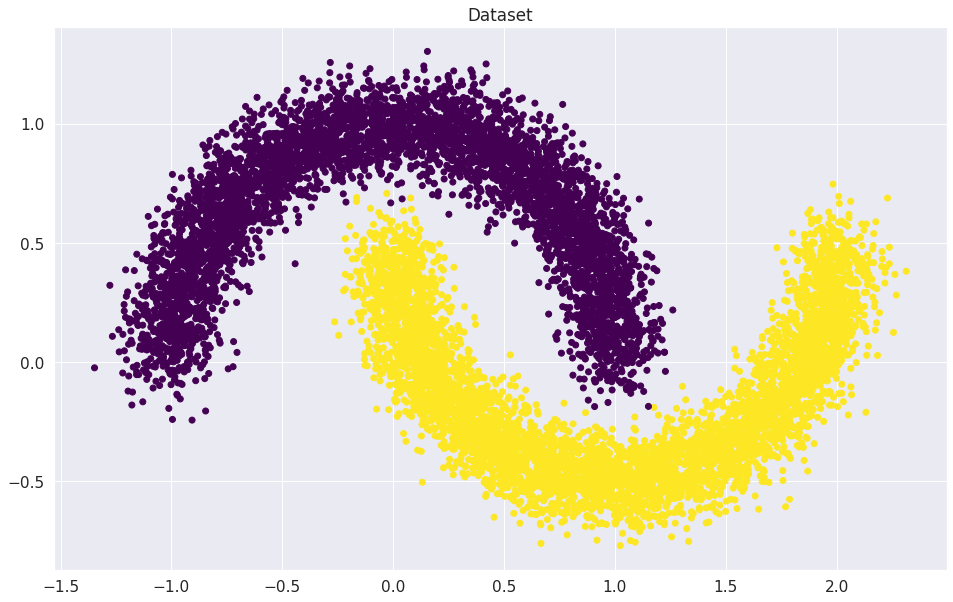

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train)# YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(1, out_features, requires_grad=True))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [9]:
linear_regression = LinearRegression(2, 1).to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [10]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-0.4664],
         [ 0.7443]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[1.]], device='cuda:0', requires_grad=True)]

**У полученной модели 3 обучаемых параметра: 2 в weights и 1 в bias**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.to(device))# YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp.flatten(), y_batch.to(device))# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)# YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4375
Iteration: 100
Batch accuracy: 0.8203125
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** В среднем требуется примерно 600 итераций, чтобы алгоритм сошелся(460, 519, 637)

### Визуализируем результаты

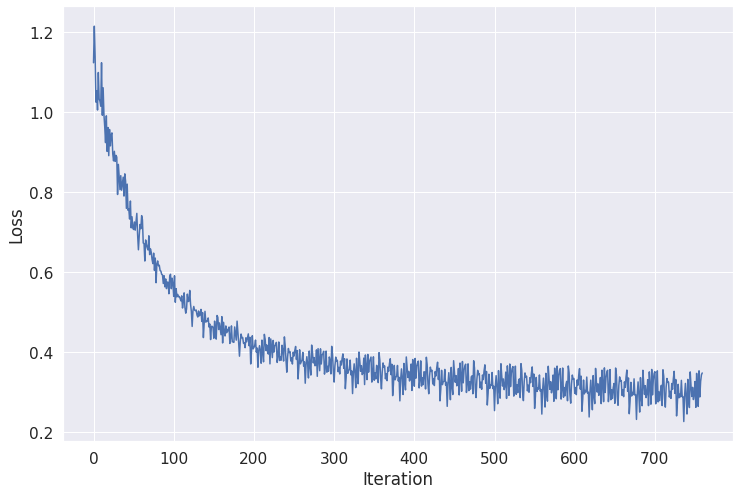

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

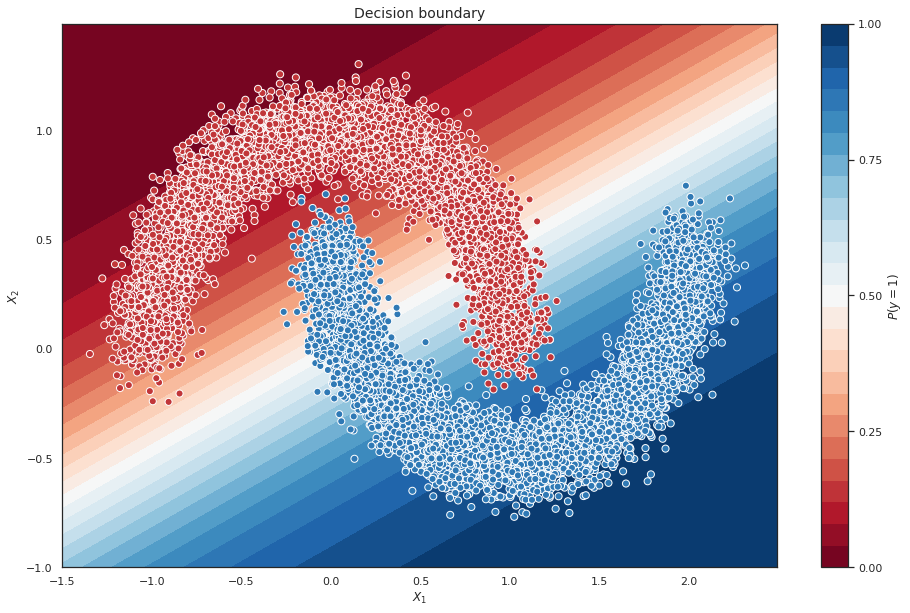

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch.to(device)).reshape(xx.shape)).cpu()
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        preds = torch.sigmoid(linear_regression(x_batch)) > 0.5 #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

predicts = predict(val_dataloader, linear_regression.cpu())# YOUR CODE. Compute total accuracy
print(f"Accuracy is {accuracy_score(y_val, predicts)}")

Accuracy is 0.8648


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** примерно 0.88

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                                shuffle=True, num_workers=2)# YOUR CODE GOES HERE
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                                shuffle=False, num_workers=2)# YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
features = 784
classes = 10

In [19]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 64),
    activation,
    nn.Linear(64, classes)).to(device)

In [20]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))# YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch.to(device))# YOUR CODE GOES HERE
            all =  x_batch.shape[0]# YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8739333333333333
Loader: valid. Accuracy: 0.9136
Epoch: 2
Loader: train. Accuracy: 0.9266666666666666
Loader: valid. Accuracy: 0.94
Epoch: 3
Loader: train. Accuracy: 0.9469
Loader: valid. Accuracy: 0.9545
Epoch: 4
Loader: train. Accuracy: 0.9575666666666667
Loader: valid. Accuracy: 0.9616
Epoch: 5
Loader: train. Accuracy: 0.96345
Loader: valid. Accuracy: 0.9639
Epoch: 6
Loader: train. Accuracy: 0.9684666666666667
Loader: valid. Accuracy: 0.966
Epoch: 7
Loader: train. Accuracy: 0.9721333333333333
Loader: valid. Accuracy: 0.9691
Epoch: 8
Loader: train. Accuracy: 0.9739833333333333
Loader: valid. Accuracy: 0.9686
Epoch: 9
Loader: train. Accuracy: 0.9766166666666667
Loader: valid. Accuracy: 0.9677
Epoch: 10
Loader: train. Accuracy: 0.9778166666666667
Loader: valid. Accuracy: 0.9707


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]

In [23]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies that returns a list of accuracies)

def test_activation_function(activation):
    #model init
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 64),
    activation,
    nn.Linear(64, classes)).to(device)

    #criterion, optimizer, loaders
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    #net
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm_notebook(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))# YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct =  torch.sum(preds == y_batch.to(device))# YOUR CODE GOES HERE
                all =  x_batch.shape[0]# YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [24]:
plain_accuracy = test_activation_function(Identical())["valid"]
relu_accuracy = test_activation_function(nn.ReLU())["valid"]#YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())["valid"]#YOUR CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.87275
Loader: valid. Accuracy: 0.9171
Epoch: 2
Loader: train. Accuracy: 0.9068666666666667
Loader: valid. Accuracy: 0.9158
Epoch: 3
Loader: train. Accuracy: 0.91145
Loader: valid. Accuracy: 0.9125
Epoch: 4
Loader: train. Accuracy: 0.9146666666666666
Loader: valid. Accuracy: 0.9209
Epoch: 5
Loader: train. Accuracy: 0.9155166666666666
Loader: valid. Accuracy: 0.9189
Epoch: 6
Loader: train. Accuracy: 0.9176333333333333
Loader: valid. Accuracy: 0.9118
Epoch: 7
Loader: train. Accuracy: 0.9175833333333333
Loader: valid. Accuracy: 0.9181
Epoch: 8
Loader: train. Accuracy: 0.9185166666666666
Loader: valid. Accuracy: 0.9187
Epoch: 9
Loader: train. Accuracy: 0.91845
Loader: valid. Accuracy: 0.9192
Epoch: 10
Loader: train. Accuracy: 0.9202166666666667
Loader: valid. Accuracy: 0.9186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.86245
Loader: valid. Accuracy: 0.914
Epoch: 2
Loader: train. Accuracy: 0.91795
Loader: valid. Accuracy: 0.9315
Epoch: 3
Loader: train. Accuracy: 0.9347833333333333
Loader: valid. Accuracy: 0.9405
Epoch: 4
Loader: train. Accuracy: 0.94625
Loader: valid. Accuracy: 0.9509
Epoch: 5
Loader: train. Accuracy: 0.9539166666666666
Loader: valid. Accuracy: 0.9528
Epoch: 6
Loader: train. Accuracy: 0.9597333333333333
Loader: valid. Accuracy: 0.9587
Epoch: 7
Loader: train. Accuracy: 0.9633
Loader: valid. Accuracy: 0.9579
Epoch: 8
Loader: train. Accuracy: 0.9658666666666667
Loader: valid. Accuracy: 0.9615
Epoch: 9
Loader: train. Accuracy: 0.9684833333333334
Loader: valid. Accuracy: 0.9643
Epoch: 10
Loader: train. Accuracy: 0.97105
Loader: valid. Accuracy: 0.9639


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8699333333333333
Loader: valid. Accuracy: 0.9165
Epoch: 2
Loader: train. Accuracy: 0.9213166666666667
Loader: valid. Accuracy: 0.9303
Epoch: 3
Loader: train. Accuracy: 0.9383166666666667
Loader: valid. Accuracy: 0.9448
Epoch: 4
Loader: train. Accuracy: 0.94975
Loader: valid. Accuracy: 0.9533
Epoch: 5
Loader: train. Accuracy: 0.9569
Loader: valid. Accuracy: 0.9535
Epoch: 6
Loader: train. Accuracy: 0.9624333333333334
Loader: valid. Accuracy: 0.9618
Epoch: 7
Loader: train. Accuracy: 0.9651666666666666
Loader: valid. Accuracy: 0.9654
Epoch: 8
Loader: train. Accuracy: 0.96965
Loader: valid. Accuracy: 0.9664
Epoch: 9
Loader: train. Accuracy: 0.9716333333333333
Loader: valid. Accuracy: 0.9669
Epoch: 10
Loader: train. Accuracy: 0.9740166666666666
Loader: valid. Accuracy: 0.9703


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

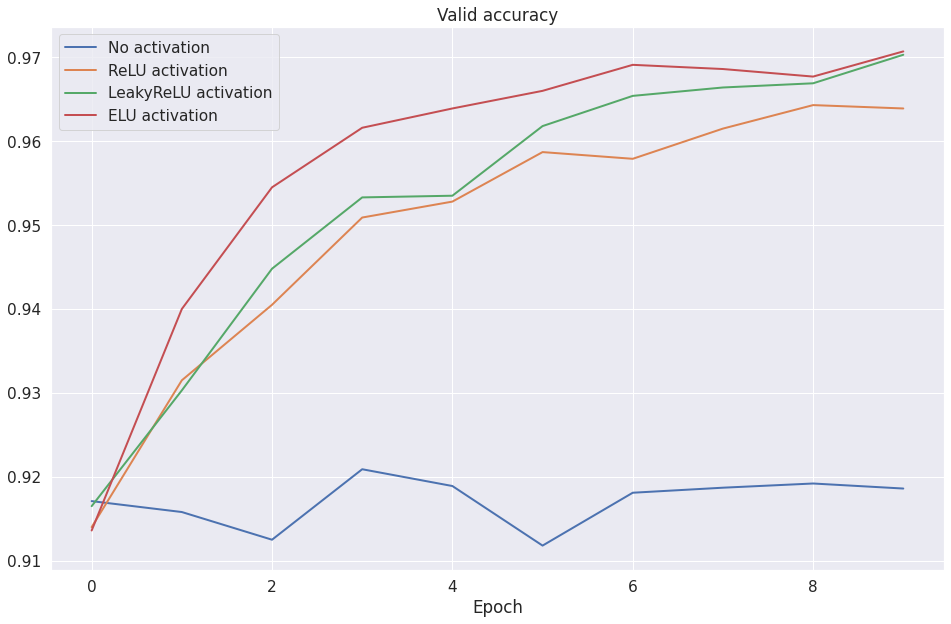

In [25]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

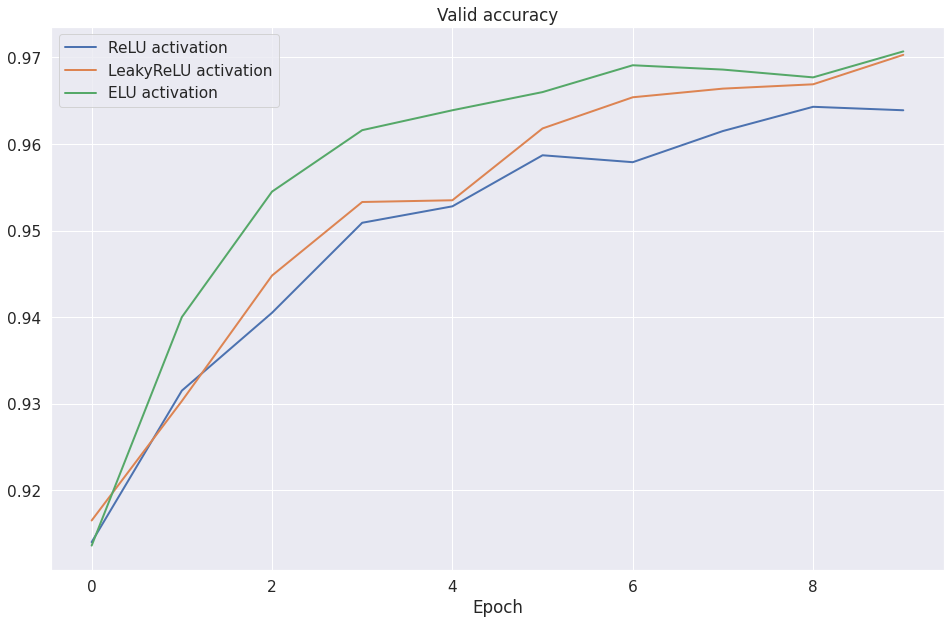

In [26]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [27]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-11 19:37:03--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-11 19:37:03--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2021-11-11 19:37:03 (1.94 MB/s) - ‘sample_photo.jpg’ saved [49337/

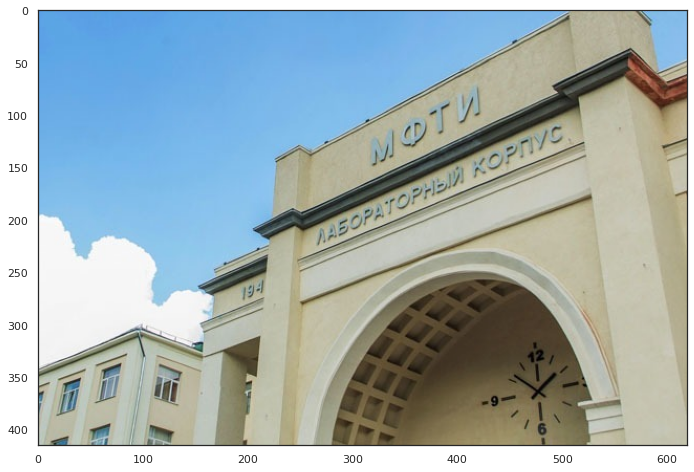

In [28]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [29]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

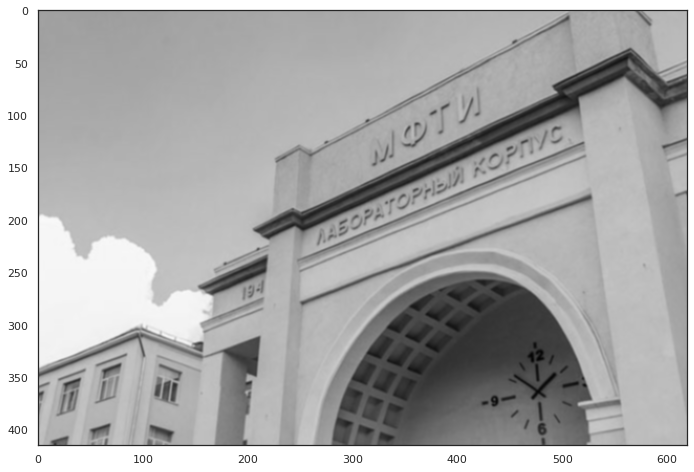

In [30]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

**1) Е**

**2) Д**

**3) A**

**4) В**

**5) Б**

**6) Г**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)#YOUR CODE
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2)#YOUR CODE
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)#YOUR CODE  
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))#YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [32]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [33]:
summary(model.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [34]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))# YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch.to(device))# YOUR CODE GOES HERE
            all =  x_batch.shape[0]# YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8863
Loader: valid. Accuracy: 0.9568
Epoch: 2
Loader: train. Accuracy: 0.9664
Loader: valid. Accuracy: 0.9762
Epoch: 3
Loader: train. Accuracy: 0.9774
Loader: valid. Accuracy: 0.982
Epoch: 4
Loader: train. Accuracy: 0.98355
Loader: valid. Accuracy: 0.9795
Epoch: 5
Loader: train. Accuracy: 0.9852666666666666
Loader: valid. Accuracy: 0.9866
Epoch: 6
Loader: train. Accuracy: 0.98795
Loader: valid. Accuracy: 0.9862
Epoch: 7
Loader: train. Accuracy: 0.9892166666666666
Loader: valid. Accuracy: 0.9858
Epoch: 8
Loader: train. Accuracy: 0.9909666666666667
Loader: valid. Accuracy: 0.9813
Epoch: 9
Loader: train. Accuracy: 0.9913666666666666
Loader: valid. Accuracy: 0.9873
Epoch: 10
Loader: train. Accuracy: 0.9931833333333333
Loader: valid. Accuracy: 0.9892


In [35]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

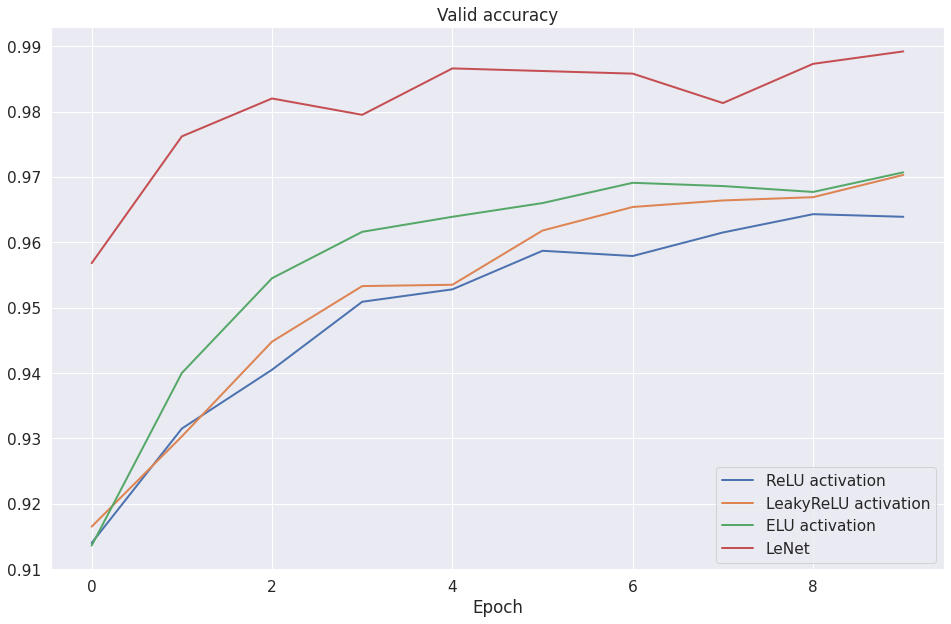

In [36]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: 0.99**